In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.regression_models import strong_regression_model_factory, weak_regression_model_factory
from utils.tools import generate_data, load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

# Generate Data

In [88]:
generate_data(t=47, subjects=250, random_sample=False)
for i in enumerate(np.linspace(0.5, 12, 47)):
    print(i)

Data Generated!
(0, 0.5)
(1, 0.75)
(2, 1.0)
(3, 1.25)
(4, 1.5)
(5, 1.75)
(6, 2.0)
(7, 2.25)
(8, 2.5)
(9, 2.75)
(10, 3.0)
(11, 3.25)
(12, 3.5)
(13, 3.75)
(14, 4.0)
(15, 4.25)
(16, 4.5)
(17, 4.75)
(18, 5.0)
(19, 5.25)
(20, 5.5)
(21, 5.75)
(22, 6.0)
(23, 6.25)
(24, 6.5)
(25, 6.75)
(26, 7.0)
(27, 7.25)
(28, 7.5)
(29, 7.75)
(30, 8.0)
(31, 8.25)
(32, 8.5)
(33, 8.75)
(34, 9.0)
(35, 9.25)
(36, 9.5)
(37, 9.75)
(38, 10.0)
(39, 10.25)
(40, 10.5)
(41, 10.75)
(42, 11.0)
(43, 11.25)
(44, 11.5)
(45, 11.75)
(46, 12.0)


# Plot Generated Data

In [89]:
model_data = load_obj('data/regression_bootstrap_data')

df = pd.DataFrame({'yobs':model_data['Yobs'],
                   'y':model_data['y_est'],
                   'times':model_data['times'],
                   'subject_ids':model_data['subject_ids']})

df.loc[:, 'condition'] = False

frames = []
for name, frame in df.groupby('subject_ids'):

#     samps = np.array([2, 8, 30])
    frame.loc[frame.times.isin([1, 2.5, 8.0]),'condition'] = True
    frames.append(frame)
    
df = pd.concat(frames, axis = 0)


condition_on = df.loc[df.condition==True,:]

X = model_data['X']
yobs = condition_on.yobs.values
times = condition_on.times.values
subject_ids = condition_on.subject_ids.values

no_condition = df.loc[df.condition==False, :]

X = model_data['X']
ytest = no_condition.yobs.values
test_times = no_condition.times.values
test_subject_ids = no_condition.subject_ids.values


/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [4]:

# g = sns.FacetGrid(data = df.query('subject_ids<25'), col='subject_ids', col_wrap=5)
# g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
# g.map_dataframe(sns.scatterplot, 'times','yobs', hue = 'condition')


# Strong Priors

In [92]:
with strong_regression_model_factory(yobs, X, times, test_times, subject_ids, test_subject_ids, use_delay = False) as strong_model:
    maps = pm.find_MAP()

logp = 1,823.6, ||grad|| = 1.1088: 100%|██████████| 720/720 [00:00<00:00, 827.40it/s]  


In [93]:
gradients = strong_model.dlogp()

In [94]:
with strong_model:
    #Prior Predictive
    prior_predictive = pm.sample_prior_predictive(1000)
    #Sample from Posterior
    trace = pm.sample(draws = 1000, 
                      tune = 1000, 
                      chains = 12, 
                      random_seed = 19920908,
                     target_accept = 0.8)
    #Posterior predictrive
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    #Turn into an InferenceData object
    strong_data = az.from_pymc3(prior=prior_predictive, 
                                trace=trace, 
                                posterior_predictive=posterior_predictive,
                                coords = {'subject_ids':np.sort(np.unique(subject_ids)) },
                                dims = {'ke':['subject_ids'],
                                        'Cl':['subject_ids'],
                                        'ka':['subject_ids'],
                                        'delays':['subject_ids']})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, betas_ka_3, betas_ka_2, betas_ka_1, s_ke, z_ke, betas_ke_3, betas_ke_2, betas_ke_1, log_alpha_log_ke_z, s_CL, z_CL, betas_CL_3, betas_CL_2, betas_CL_1, log_CL]
100%|██████████| 12000/12000 [00:23<00:00, 503.01it/s]


In [95]:
with strong_model:
    strong_posterior_predictions = pm.sample_posterior_predictive(trace, var_names=['ypred'])

100%|██████████| 12000/12000 [00:27<00:00, 431.71it/s]


/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/demetri/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


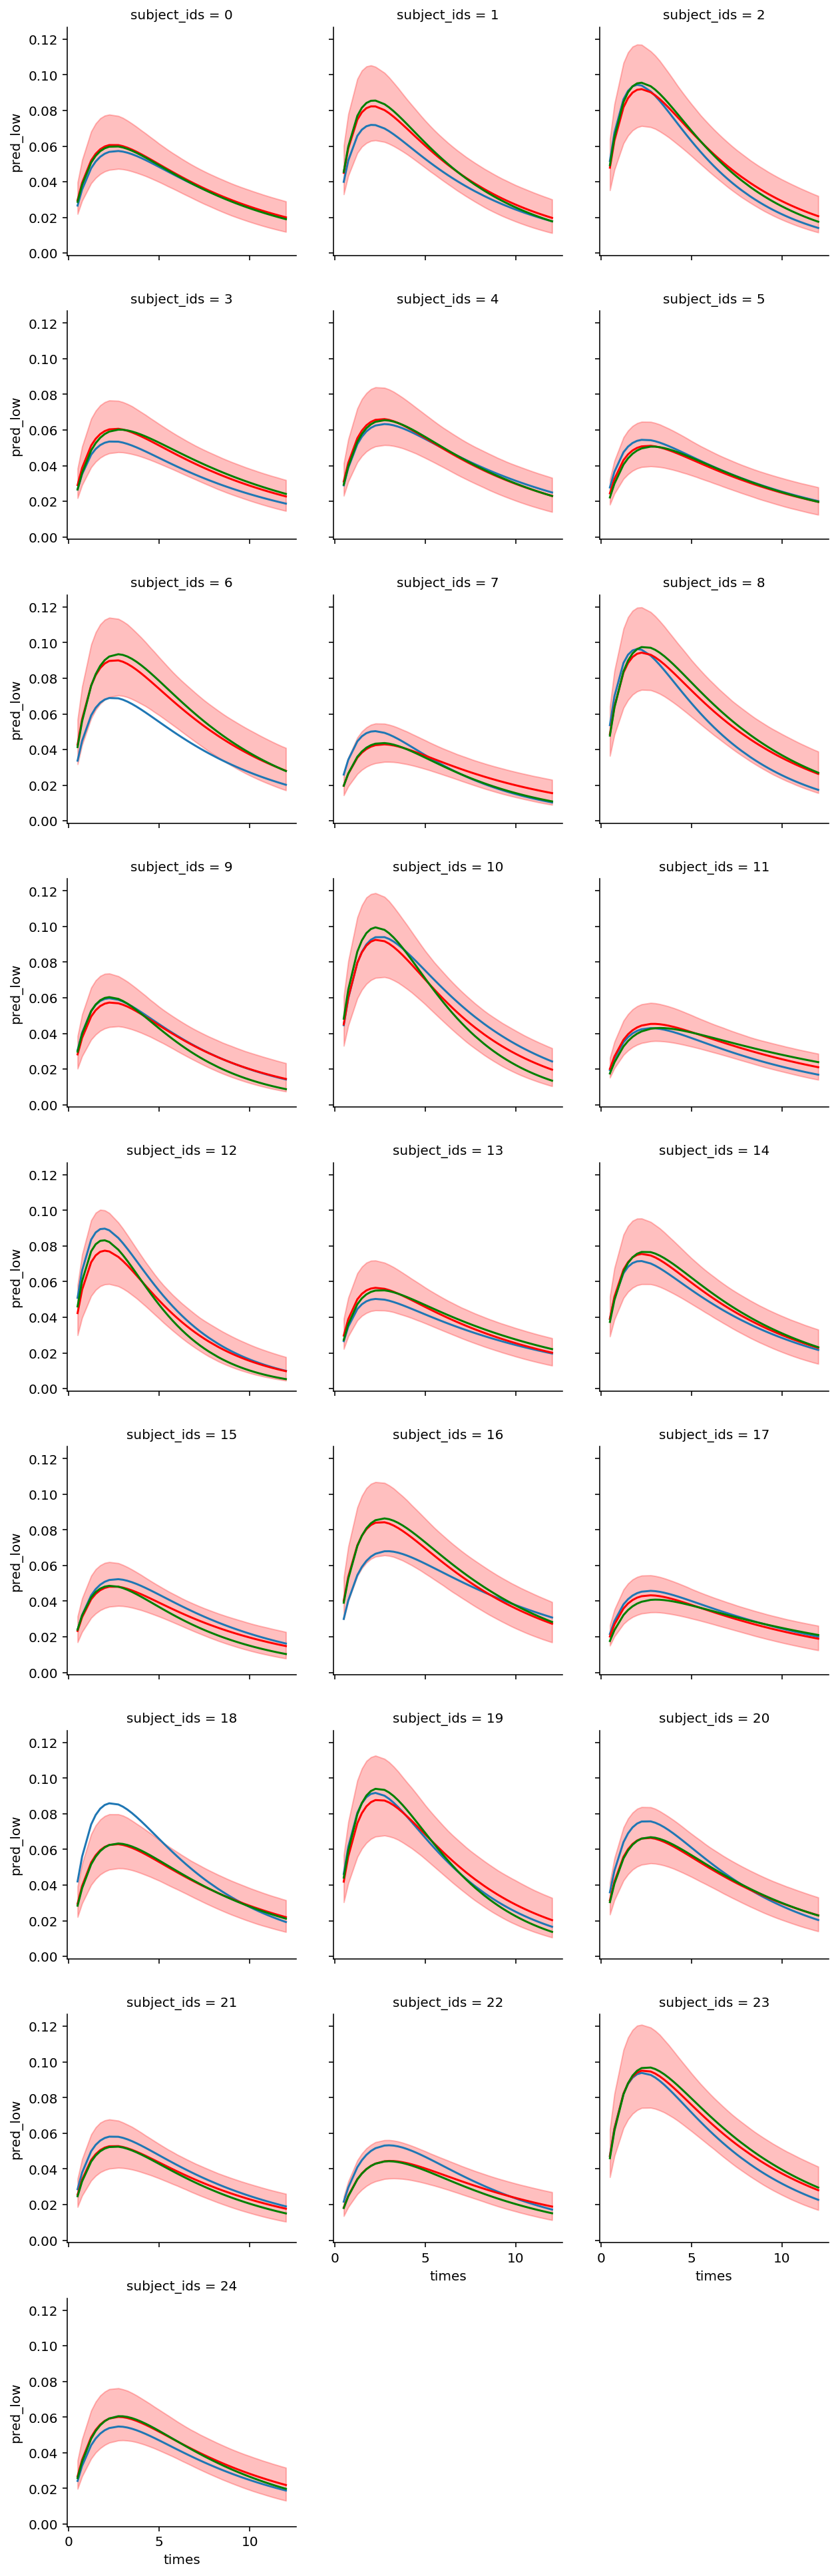

In [96]:
no_condition.loc[:,'pred'] = np.mean(strong_posterior_predictions['ypred'], axis = 0)
no_condition.loc[:,'pred_low'] = np.quantile(strong_posterior_predictions['ypred'], 0.025, axis = 0 )
no_condition.loc[:,'pred_high'] = np.quantile(strong_posterior_predictions['ypred'], 0.975, axis = 0 )
no_condition.loc[:,'map_pred'] = maps['ypred']

g = sns.FacetGrid(data = no_condition.query('subject_ids<25'), col='subject_ids', col_wrap=3)
g.map_dataframe(sns.lineplot, 'times','y', estimator = None)
# g.map_dataframe(sns.scatterplot, 'times','yobs')
g.map_dataframe(sns.lineplot, 'times','pred', estimator = None, color = 'red')
g.map_dataframe(sns.lineplot, 'times','map_pred', estimator = None, color = 'g')

g.map_dataframe(plt.fill_between, 'times', 'pred_low', 'pred_high', alpha = 0.25, color = 'red')

In [113]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(1000*no_condition.y, 1000*no_condition.pred)).round(6))
print(np.sqrt(mean_squared_error(1000*no_condition.y, 1000*no_condition.map_pred)).round(6))

6.809963
7.865935


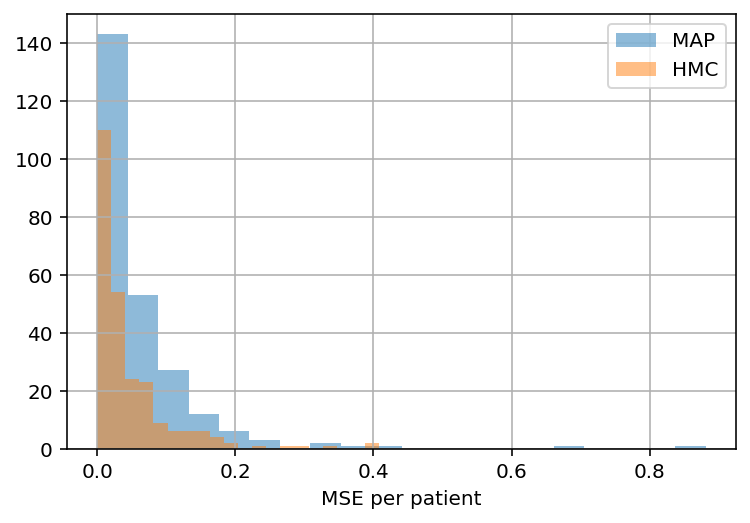

In [98]:
no_condition.groupby('subject_ids').apply(lambda x: 1000*mean_squared_error(x.y, x.map_pred)).hist(bins = 20, alpha = 0.5, label = 'MAP')
no_condition.groupby('subject_ids').apply(lambda x: 1000*mean_squared_error(x.y, x.pred)).hist(bins = 20, alpha = 0.5, label = 'HMC')
plt.xlabel('MSE per patient')
plt.legend()


In [99]:
ke = np.exp(maps['log_ke'] + maps['z_ke']*maps['s_ke'])
ka = np.exp(maps['log_ka'] + maps['z_ka']*maps['s_ka'])
map_tmax = np.log(ka/ke)/(ka-ke)


In [100]:
hmc = strong_data.posterior
ke = np.exp(hmc.log_ke.mean() + hmc.z_ke.mean(axis =(0,1))*hmc.s_ke.mean() ).values
ka = np.exp(hmc.log_ka.mean() + hmc.z_ka.mean(axis =(0,1))*hmc.s_ka.mean() ).values
hmc_tmax =  np.log(ka/ke)/(ka-ke)

np.log(ka/ke).shape

(250,)

In [101]:
ke = np.exp(model_data['log_ke'] + model_data['z_ke']*model_data['s_ke'])
ka = np.exp(model_data['log_ka'] + model_data['z_ka']*model_data['s_ka'])
actual_tmax = np.log(ka/ke)/(ka-ke)


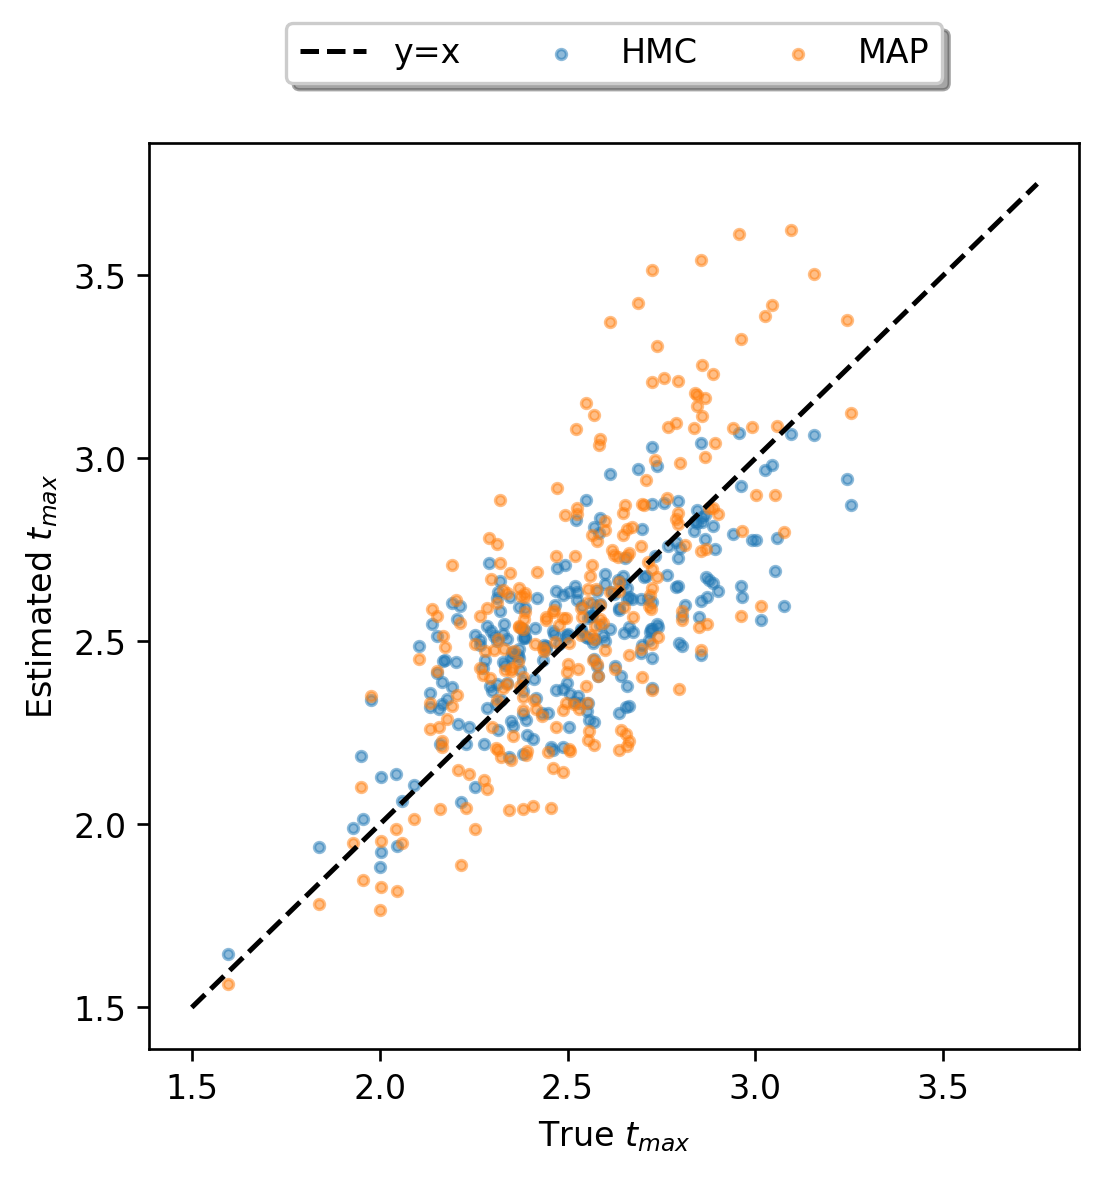

In [102]:

x = np.linspace(1.5, 3.75, 101)
fig,ax = plt.subplots(dpi = 120, figsize = (5,5))
ax.scatter(actual_tmax, hmc_tmax,marker = '.', alpha = 0.5, label = 'HMC')
ax.scatter(actual_tmax, map_tmax, marker = '.', alpha = 0.5, label = 'MAP')
ax.plot(x,x,'k--', label = 'y=x')
ax.set_xlabel(r'True $t_{max}$')
ax.set_ylabel(r'Estimated $t_{max}$')
# ax.set_aspect('equal')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)




In [111]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(actual_tmax, hmc_tmax)))
print(np.sqrt(mean_squared_error(actual_tmax, map_tmax)))

0.1857727514109992
0.26232036969539524


In [116]:
x = np.random.normal(10,1, size = 100)

In [118]:
1 - np.sum((x - 0)**2)/np.var(x)

-10509.365994351887

In [13]:
N=10
y = np.zeros(N)
y[:4] = 1

with pm.Model() as model:
    
    theta = pm.Uniform('theta', 0, 1)
    
    y = pm.Bernoulli('y', theta, observed = y)
    
    trace = pm.sample()
    
    maps = pm.find_MAP(tol=1e-8, options = {'gtol':1e-6})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:00<00:00, 3698.76draws/s]
logp = -6.9315, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1547.24it/s]


In [14]:
maps

{'theta_interval__': array(-0.4054651), 'theta': array(0.4)}

In [39]:
N=10
y = np.zeros(N)
y[:4] = 1
import theano.tensor as tt
with pm.Model() as model:
    
    alpha = pm.Flat('alpha')
    theta = pm.Deterministic('theta',pm.invlogit(alpha))
    constrain = pm.Potential('constrain', tt.log(theta)+tt.log(1-theta))
    y = pm.Bernoulli('y', theta, observed = y)
    
    trace = pm.sample(draws=2000)
    
    maps = pm.find_MAP(tol=1e-8, options = {'gtol':1e-6})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:01<00:00, 4201.40draws/s]
logp = -8.3178, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 2417.23it/s]


In [40]:

1/(1+np.exp(-maps['alpha']))

0.416666668660107

In [42]:
trace['theta'].mean().round(2)

0.42